In [22]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
import env
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def acquire_zillow_sfr():
    '''
    This function will retrieve zillow home data for 2017 properties. It will only get
    single family residential properties. the function will attempt to open the data from 
    a local csv file, if one is not found, it will download the data from the codeup
    database. An env file is needed in the local directory in order to run this file.
    '''
    if os.path.exists('zillow_2017_sfr.csv'):
        print('opening data from local file')
        df = pd.read_csv('zillow_2017_sfr.csv', index_col=0)
    else:
        # run sql query and write to csv
        print('local file not found')
        print('retrieving data from sql server')
        query = '''
WITH cte_sfr as(
	SELECT * 
    FROM properties_2017
    WHERE propertylandusetypeid IN (
		SELECT propertylandusetypeid
		FROM propertylandusetype
		WHERE propertylandusedesc IN( 
			"Single Family Residential", "Inferred Single Family Residential"))
	AND parcelid IN (
		SELECT parcelid
        FROM predictions_2017)
)

SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
	garagecarcnt, garagetotalsqft, lotsizesquarefeet, poolcnt, poolsizesum,
	yearbuilt, fips, regionidcity, taxvaluedollarcnt, taxamount
FROM cte_sfr
;
        '''
        connection = env.get_db_url('zillow')
        df = pd.read_sql(query, connection)
        df.to_csv('zillow_2017_sfr.csv')
    
    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'garagecarcnt':'cars_garage',
                              'garagetotalsqft':'garage_sqft',
                              'lotsizesquarefeet':'lot_size',
                              'poolcnt':'pools',
                              'poolsizesum':'pools_size',
                              'regionidcity':'region',
                              'yearbuilt':'year_built',
                              'taxvaluedollarcnt':'tax_value', 
                              'taxamount':'annual_tax',
                              })
    return df

In [5]:
df = acquire_zillow_sfr()

local file not found
retrieving data from sql server


In [6]:
df.head()

,bedrooms,bathrooms,area,cars_garage,garage_sqft,lot_size,pools,pools_size,year_built,fips,region,tax_value,annual_tax
0,4.0,3.5,3100.0,2.0,633.0,4506.0,NaN,NaN,1998.0,6059.0,53571.0,1023282.0,11013.72
1,2.0,1.0,1465.0,1.0,0.0,12647.0,NaN,NaN,1967.0,6111.0,13091.0,464000.0,5672.48
2,3.0,2.0,1243.0,2.0,440.0,8432.0,1.0,NaN,1962.0,6059.0,21412.0,564778.0,6488.30
3,4.0,3.0,2376.0,NaN,NaN,13038.0,1.0,NaN,1970.0,6037.0,396551.0,145143.0,1777.51
4,4.0,3.0,2962.0,NaN,NaN,63000.0,1.0,NaN,1950.0,6037.0,47019.0,773303.0,9516.26


In [24]:
def get_hist(df, exclude=['fips', 'year_built']):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 12))

    # List of columns
    cols = [col for col in df.columns if col not in exclude]

    for i, col in enumerate(cols):
        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 
        # Create subplot.
        plt.subplot(2, math.ceil(len(cols) /2), plot_number)
        # Title with column name.
        plt.title(col)
        # Display histogram for column.
        df[col].hist(bins=5)
        # Hide gridlines.
        plt.grid(False)
        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)
        plt.tight_layout()
    plt.show()
        
        
def get_box(df, cols=['bedrooms', 'bathrooms', 'area', 'tax_value', 'annual_tax']):
    ''' Gets boxplots of acquired continuous variables'''
    
    plt.figure(figsize=(16, 12))
    
    for i, col in enumerate(cols):
        # i starts at 0, but plot should start at 1
        plot_number = i + 1 
        # Create subplot.
        plt.subplot(2, math.ceil(len(cols) / 2,), plot_number)
        # Title with column name.
        plt.title(col)
        # Display boxplot for column.
        sns.boxplot(data=df[[col]])
        # Hide gridlines.
        plt.grid(False)
        # sets proper spacing between plots
        plt.tight_layout()
    plt.show()

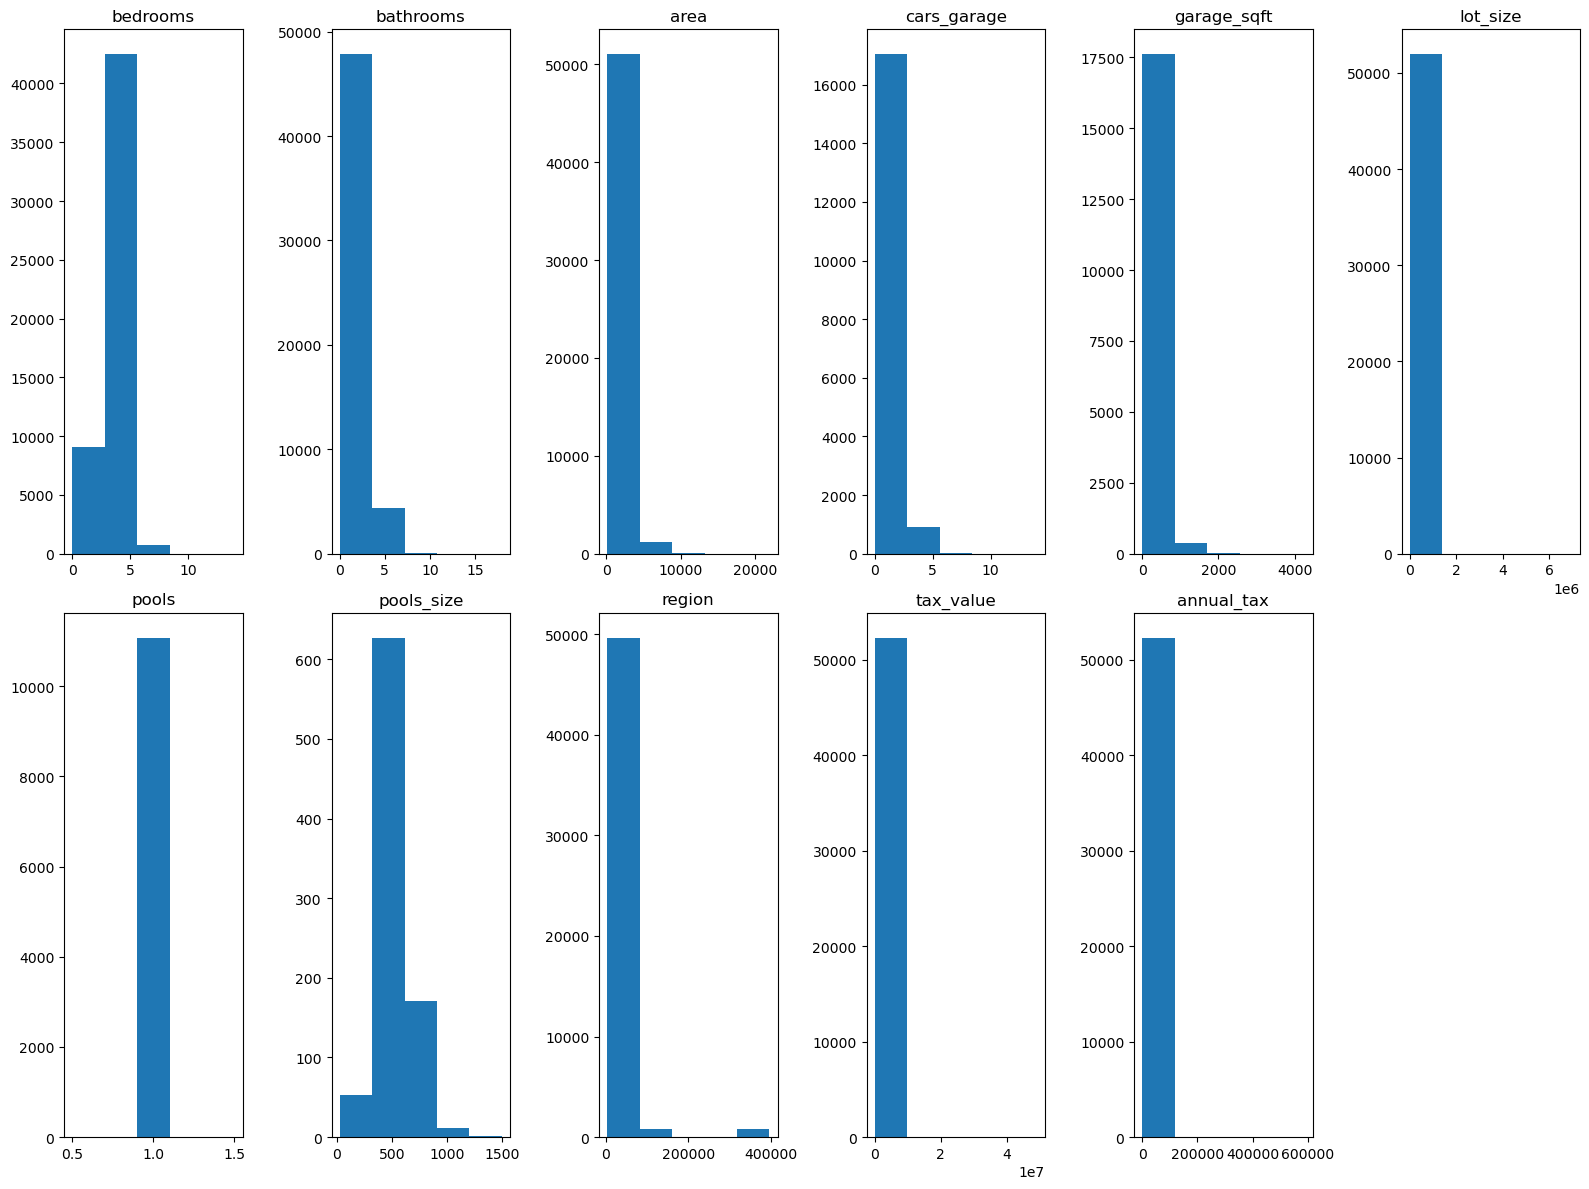

In [35]:
get_hist(df)

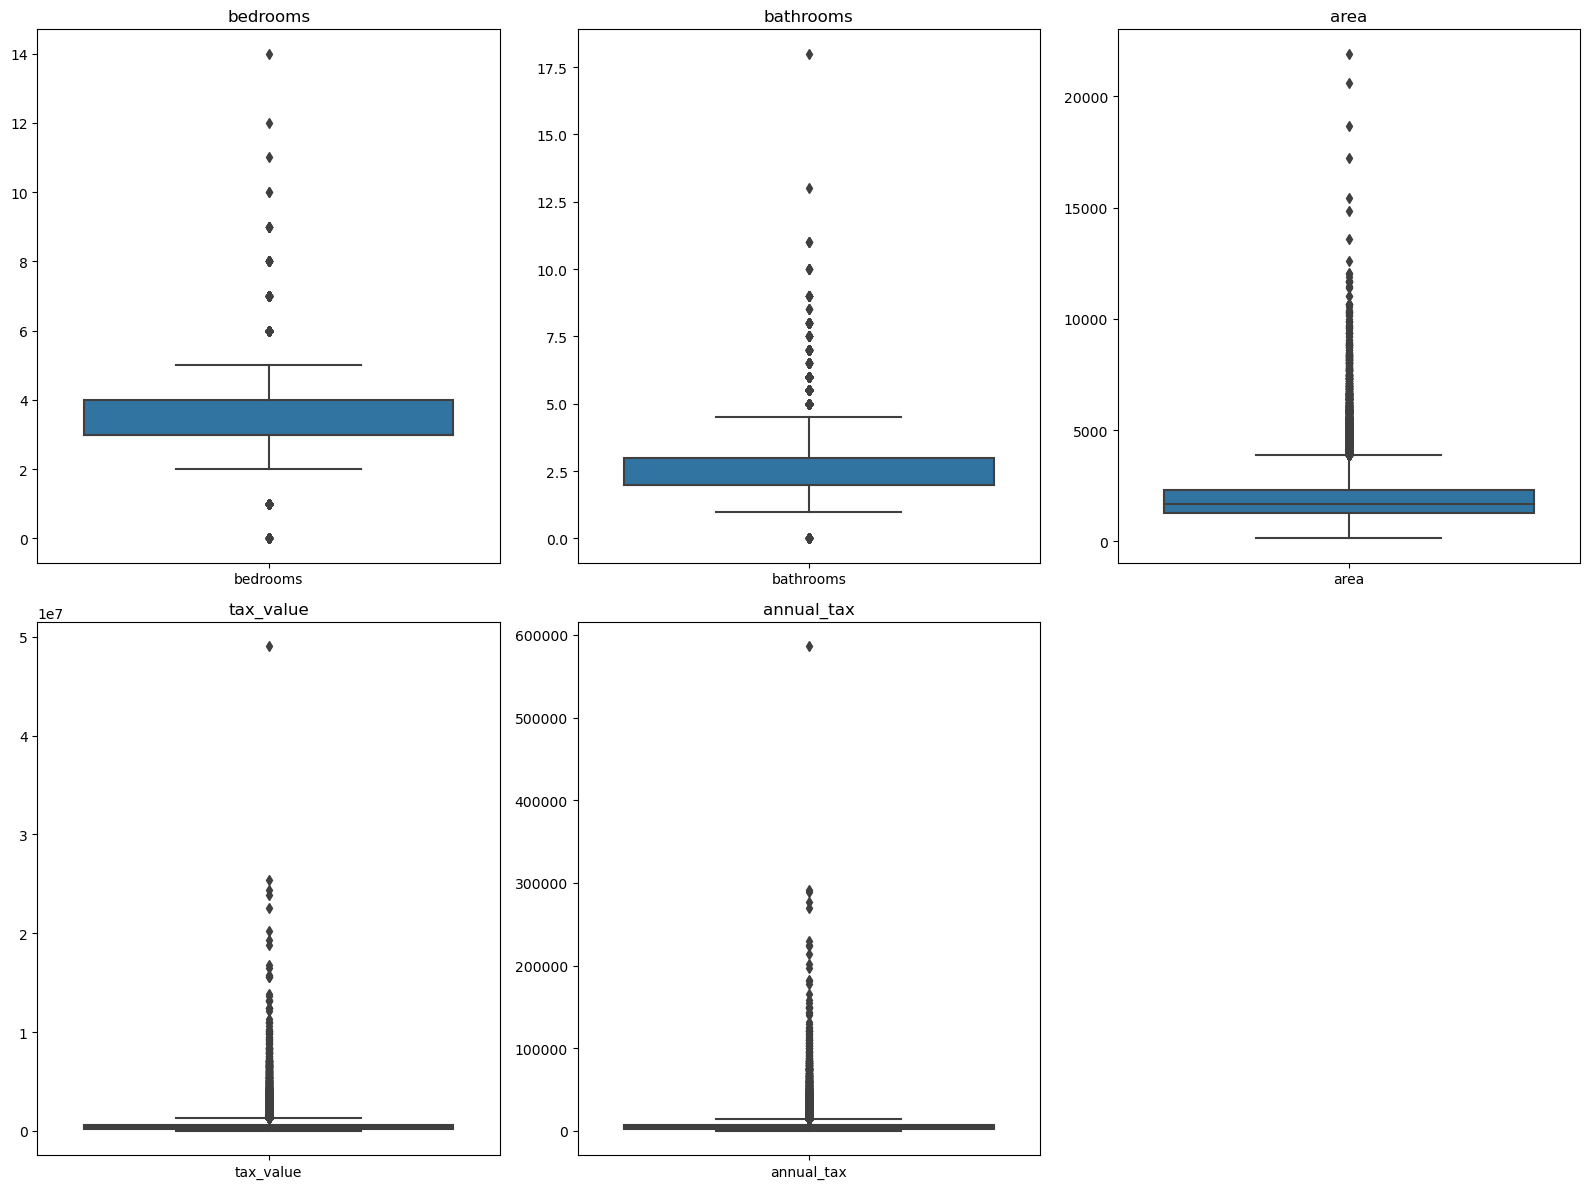

In [36]:
get_box(df)

In [27]:
def remove_outliers(df, col_list, k=1.5):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    for col in col_list:
        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [37]:
def clean_zillow_sfr(df, 
                     out_cols=['bedrooms', 'bathrooms', 'area', 
                              'tax_value', 'annual_tax'], 
                     drop_cols=['year_built']):
    '''
    this function will take in a DataFrame of zillow single family resident data,
    it will then remove rows will null values, then remove rows with 0 bedrooms or 
    0 bathrooms, it will then change dtypes of bedroomcnt, calculatedfinishedsquarefeet,
    taxvaluedollarcnt, yearbuilt, and fips to integer, then return the cleaned df
    '''
    # removing outliers
#     df = remove_outliers(df, out_cols)
    # remove the nonsensical 2br 2 bath houses with less than 100 sq feet
#     df = df[df.area > 100]
    

    # remove null values
#     df = df[drop_cols].dropna()

    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # converting column datatypes
    # change dtypes of columns to int
    df.bedrooms = df.bedrooms.astype(int)
    df.area = df.area.astype(int)
    df.year_built = df.year_built.astype(int)
    df.tax_value = df.tax_value.astype(int)
    df.fips = df.fips.astype(int)

    # return the cleaned dataFrame
    return df

In [29]:
def split_zillow(df):
    '''
    this function will take in a cleaned zillow dataFrame and return the data split into
    train, validate and test dataframes in preparation for ml modeling.
    '''
    train_val, test = train_test_split(df,
                                      random_state=1342,
                                      train_size=0.8)
    train, validate = train_test_split(train_val,
                                      random_state=1342,
                                      train_size=0.7)
    return train, validate, test

In [31]:
def wrangle_zillow():
    '''
    This function will acquire the zillow dataset, clean the data, and split it
    and return the data as train, validate, test
    '''
    return split_zillow(
        clean_zillow_sfr(
            acquire_zillow_sfr()))

In [30]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedrooms', 'bathrooms', 'tax_value'],
               scaler=MinMaxScaler(),
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(
        scaler.transform(train[columns_to_scale]),
        columns=train[columns_to_scale].columns.values, 
        index = train.index)
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(
        scaler.transform(validate[columns_to_scale]),
        columns=validate[columns_to_scale].columns.values).set_index(
        [validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(
        test[columns_to_scale]), 
        columns=test[columns_to_scale].columns.values).set_index(
        [test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [40]:
df.head()

,bedrooms,bathrooms,area,cars_garage,garage_sqft,lot_size,pools,pools_size,year_built,fips,region,tax_value,annual_tax
0,4.0,3.5,3100.0,2.0,633.0,4506.0,NaN,NaN,1998.0,6059.0,53571.0,1023282.0,11013.72
1,2.0,1.0,1465.0,1.0,0.0,12647.0,NaN,NaN,1967.0,6111.0,13091.0,464000.0,5672.48
2,3.0,2.0,1243.0,2.0,440.0,8432.0,1.0,NaN,1962.0,6059.0,21412.0,564778.0,6488.30
3,4.0,3.0,2376.0,NaN,NaN,13038.0,1.0,NaN,1970.0,6037.0,396551.0,145143.0,1777.51
4,4.0,3.0,2962.0,NaN,NaN,63000.0,1.0,NaN,1950.0,6037.0,47019.0,773303.0,9516.26


In [47]:
df[df.cars_garage.isna()]

,bedrooms,bathrooms,area,cars_garage,garage_sqft,lot_size,pools,pools_size,year_built,fips,region,tax_value,annual_tax
3,4.0,3.0,2376.0,NaN,NaN,13038.0,1.0,NaN,1970.0,6037.0,396551.0,145143.0,1777.51
4,4.0,3.0,2962.0,NaN,NaN,63000.0,1.0,NaN,1950.0,6037.0,47019.0,773303.0,9516.26
5,2.0,1.0,738.0,NaN,NaN,4214.0,NaN,NaN,1922.0,6037.0,45457.0,218552.0,2366.08
6,4.0,3.0,3039.0,NaN,NaN,20028.0,NaN,NaN,1970.0,6037.0,14634.0,220583.0,3104.19
7,4.0,3.0,2540.0,NaN,NaN,10384.0,1.0,NaN,1999.0,6037.0,54311.0,430108.0,6103.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,3.0,2.0,1570.0,NaN,NaN,7499.0,NaN,NaN,1958.0,6037.0,12447.0,72026.0,1000.70
52315,4.0,2.0,1633.0,NaN,NaN,4630.0,NaN,NaN,1962.0,6037.0,30267.0,346534.0,4175.08
52316,2.0,2.0,1286.0,NaN,NaN,47405.0,NaN,NaN,1940.0,6037.0,12447.0,354621.0,4478.43
52318,3.0,1.0,1032.0,NaN,NaN,5074.0,NaN,NaN,1954.0,6037.0,36502.0,49546.0,876.43


In [42]:
df.cars_garage.value_counts(dropna=False)

NaN     34336
2.0     14777
1.0      2197
3.0       621
4.0       253
0.0        65
5.0        45
6.0        13
7.0         3
10.0        3
8.0         2
9.0         2
11.0        1
13.0        1
14.0        1
Name: cars_garage, dtype: int64

In [44]:
df.garage_sqft.value_counts(dropna=False)

NaN       34336
400.0       786
441.0       678
462.0       658
360.0       646
          ...  
1006.0        1
275.0         1
1056.0        1
261.0         1
957.0         1
Name: garage_sqft, Length: 840, dtype: int64